In [11]:
! pip install git+https://github.com/modAL-python/modAL.git
! pip install scikeras

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-fbh38ial
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-fbh38ial
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


# Import Libraries

In [22]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import numpy as np
from tensorflow.keras.datasets import cifar10,fashion_mnist
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling,margin_sampling, entropy_sampling
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="All log messages before absl::InitializeLog() is called are written to STDERR")

# Creat Imbalanced_data

In [13]:
def create_imbalanced_data(data, imbalance_ratios):
    (X_train, y_train), (X_test, y_test) = data
    
    # Initialize lists to store indices of samples to keep
    train_indices_to_keep = []
    test_indices_to_keep = []
    
    # Loop through each class
    for label in np.unique(y_train):
        # Get the indices of samples belonging to the current class
        train_indices = np.where(y_train == label)[0]
        test_indices = np.where(y_test == label)[0]
        
        # Determine the number of samples to keep for this class based on the imbalance ratio
        num_samples_to_keep_train = int(len(train_indices) * imbalance_ratios.get(label, 1.0))
        num_samples_to_keep_test = int(len(test_indices) * imbalance_ratios.get(label, 1.0))
        
        # Randomly select samples to keep
        train_indices_to_keep.extend(np.random.choice(train_indices, size=num_samples_to_keep_train, replace=False))
        test_indices_to_keep.extend(np.random.choice(test_indices, size=num_samples_to_keep_test, replace=False))
    
    # Filter the data to keep only the selected samples
    imbalanced_X_train, imbalanced_y_train = X_train[train_indices_to_keep], y_train[train_indices_to_keep]
    imbalanced_X_test, imbalanced_y_test = X_test[test_indices_to_keep], y_test[test_indices_to_keep]
    
    return (imbalanced_X_train, imbalanced_y_train), (imbalanced_X_test, imbalanced_y_test)

# Load Datasets

In [14]:
datasets = {
    "CIFAR-10": cifar10.load_data(),
    "Fashion MNIST": fashion_mnist.load_data(),
    "Imbalance Fashion MINIST":create_imbalanced_data(fashion_mnist.load_data(), {0: 0.5, 1: 0.5,3:0.25,5:0.1,6:0.8})
}

# Preprocessing Datasets

In [15]:
def preprocess_data(data, dataset_name):
    
    if dataset_name == "CIFAR-10":
        (X_train, y_train), (X_test, y_test) = data
        X_train = X_train.astype('float32') / 255
        X_test = X_test.astype('float32') / 255
        y_train = tf.keras.utils.to_categorical(y_train, 10)    # One hot encoding
        y_test = tf.keras.utils.to_categorical(y_test, 10)
        input_shape = (32, 32, 3)
        
        
    elif dataset_name == "Fashion MNIST" or dataset_name == "Imbalance Fashion MINIST":
        (X_train, y_train), (X_test, y_test) = data
        X_train = X_train.astype('float32') / 255
        X_test = X_test.astype('float32') / 255
        X_train = np.expand_dims(X_train, axis=-1)            # Reshape the data to match the input shape of the neural network (28*28*1)
        X_test = np.expand_dims(X_test, axis=-1)         
        y_train = tf.keras.utils.to_categorical(y_train, 10)     # One hot encoding
        y_test = tf.keras.utils.to_categorical(y_test, 10)
        input_shape = (28, 28, 1)
    else:
        raise ValueError("Invalid dataset name")
        
    return X_train, y_train, X_test, y_test, input_shape

# Random Sampling Function

In [16]:
def Random_Sampling(classifier, X_pool, n_instances=1):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

# Query_strategies

In [17]:
query_strategies = {
    
    # model is most uncertain, based on the prediction probabilities.
    "Uncertainty_Sampling": uncertainty_sampling,
    
    # instances are selected randomly for labeling.
    "Random_Sampling": Random_Sampling,

    # It focuses on instances where the model is unsure between two possible outcomes.
    "Margin_Sampling": margin_sampling,

    # selects instances based on the highest entropy in the prediction probabilities,
    # the highest uncertainty across all possible outcomes.
    "Entropy_Sampling": entropy_sampling
}

# Define neural network architecture

In [18]:
# takes input shape of each data set.
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
# Define the number of queries and cycles
n_instances = 3000
n_queries=10

# Create an empty dictionary to store accuracy results for different query strategies
accuracy_results = {}

In [20]:
# Loop over datasets
for dataset_name, data in datasets.items():
    print(f"Dataset: {dataset_name}")
    
    # Preprocess the data
    X_train, y_train, X_test, y_test, input_shape = preprocess_data(data, dataset_name)

    # Define initial training set
    n_initial = 2000
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_training_initial, y_training_initial = X_train[initial_idx], y_train[initial_idx]
    
    # Remove the initial data from the training dataset
    X_pool = np.delete(X_train, initial_idx, axis=0)
    y_pool = np.delete(y_train, initial_idx, axis=0)

    # Loop over query strategies
    for strategy_name, query_strategy in query_strategies.items():
        print(f"Query Strategy: {strategy_name}")   
        accuracy_list = []
        f1_list = []
        
        X_training = np.copy(X_training_initial)
        y_training = np.copy(y_training_initial)

        # Make a copy of the pool for each strategy
        X_pool_strategy = np.copy(X_pool)
        y_pool_strategy = np.copy(y_pool)
        
        # Create the model
        num_classes = y_train.shape[1]
        model = create_model(input_shape, num_classes)
        optimizer = Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        estimator = KerasClassifier(model)

            # Initialize an active learner
        learner = ActiveLearner(
            estimator=estimator,
            query_strategy=query_strategy,
            X_training=X_training,
            y_training=y_training
        )
        for i in range(n_queries):
            # Query the learner to obtain the index of the most informative sample
            query_idx, _ = learner.query(X_pool_strategy, n_instances)

            # Teach the learner with the queried sample
            if strategy_name == "Random_Sampling":
                y_reshaped = y_pool_strategy[query_idx].reshape(1, -1)  # Reshape to (1, num_classes)
            else:
                y_reshaped = y_pool_strategy[query_idx]

            learner.teach(X_pool_strategy[query_idx].reshape(-1, *input_shape), y_reshaped, only_new=True, verbose=1)

            # remove queried instance from pool
            X_pool_strategy = np.delete(X_pool_strategy, query_idx, axis=0)
            y_pool_strategy = np.delete(y_pool_strategy, query_idx, axis=0)

            # Evaluate the model's performance after teaching
            accuracy = learner.score(X_test, y_test)
            y_pred = learner.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='weighted')
            print(f"Iteration {i+1}: Accuracy = {accuracy:.2f}, F1-score = {f1:.2f}")
            accuracy_list.append(accuracy)
            f1_list.append(f1)

        print("\n")
        accuracy_results.setdefault(dataset_name, {}).setdefault(strategy_name, {"accuracy": accuracy_list, "f1_score": f1_list})


Dataset: CIFAR-10
Query Strategy: Uncertainty_Sampling


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1253 - loss: 2.3012

W0000 00:00:1714586076.272693     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1246 - loss: 2.3006
  99/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714586079.654198     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1850 - loss: 2.1689


W0000 00:00:1714586084.387975     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.10, F1-score = 0.02
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1627 - loss: 2.3207
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 2: Accuracy = 0.17, F1-score = 0.09
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1716 - loss: 2.2662
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.23, F1-score = 0.16
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


W0000 00:00:1714586104.484952     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1762 - loss: 2.1878
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 4: Accuracy = 0.19, F1-score = 0.11
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2340 - loss: 2.0417
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 5: Accuracy = 0.30, F1-score = 0.27
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2100 - loss: 2.1172
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 6: Accuracy = 0.31, F1-score = 0.28
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2514 - loss: 2.0300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 7: Accuracy = 0.34, F1-score = 0.31
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1337 - loss: 2.2977

W0000 00:00:1714586142.851768     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1342 - loss: 2.2971
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - accuracy: 0.0000e+00 - loss: 2.3502
103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714586145.976394     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.13, F1-score = 0.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2.2074
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.14, F1-score = 0.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2.2624
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 3: Accuracy = 0.15, F1-score = 0.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 2.3246
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.15, F1-score = 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2.3565
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 5: Accuracy = 0.15, F1-score = 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1163 - loss: 2.3014

W0000 00:00:1714586171.223890     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1164 - loss: 2.3007
 103/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

W0000 00:00:1714586174.278924     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1913 - loss: 2.2604


W0000 00:00:1714586178.635847     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.12, F1-score = 0.05
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2276 - loss: 2.1430
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.21, F1-score = 0.14
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1867 - loss: 2.1443
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 3: Accuracy = 0.26, F1-score = 0.22
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


W0000 00:00:1714586198.662586     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2381 - loss: 2.0825
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 4: Accuracy = 0.30, F1-score = 0.27
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2680 - loss: 1.9552
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 5: Accuracy = 0.35, F1-score = 0.34
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2273 - loss: 1.9658
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 6: Accuracy = 0.37, F1-score = 0.36
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2438 - loss: 1.9097
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 7: Accuracy = 0.36, F1-score = 0.34
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1001 - loss: 2.3010

W0000 00:00:1714586237.673373     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1010 - loss: 2.3002
 102/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714586240.751993     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1556 - loss: 2.2151


W0000 00:00:1714586245.045969     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 1: Accuracy = 0.12, F1-score = 0.04
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1495 - loss: 2.3240
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2: Accuracy = 0.14, F1-score = 0.09
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1867 - loss: 2.2165
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 3: Accuracy = 0.24, F1-score = 0.19
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


W0000 00:00:1714586264.853747     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2035 - loss: 2.1805
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.24, F1-score = 0.19
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1999 - loss: 2.1434
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 5: Accuracy = 0.29, F1-score = 0.24
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2851 - loss: 1.9915
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 6: Accuracy = 0.28, F1-score = 0.24
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2104 - loss: 2.0843
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Iteration 7: Accuracy = 0.31, F1-score = 0.28
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1869 - loss: 2.2782
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3441 - loss: 2.0369
  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step

W0000 00:00:1714586312.604333     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.13, F1-score = 0.06
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1714586317.156294     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4218 - loss: 1.8334
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.11, F1-score = 0.03
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4181 - loss: 1.7425
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.32, F1-score = 0.26
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 0.9488
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.37, F1-score = 0.32
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6118 - loss: 0.9815
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 5: Accuracy = 0.57, F1-score = 0.51
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1451 - loss: 2.2606
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.1924
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1: Accuracy = 0.38, F1-score = 0.28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 2.1382
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.38, F1-score = 0.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 1.7873
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.37, F1-score = 0.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2.2126
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.38, F1-score = 0.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 1.8966
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1404 - loss: 2.2683
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2653 - loss: 1.9197
  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

W0000 00:00:1714586385.722083     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.31, F1-score = 0.24
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


W0000 00:00:1714586389.891569     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4426 - loss: 1.5944
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.58, F1-score = 0.52
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4837 - loss: 1.4080
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.63, F1-score = 0.63
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5079 - loss: 1.2181
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.66, F1-score = 0.65
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5567 - loss: 1.0698
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 5: Accuracy = 0.73, F1-score = 0.71
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1111 - loss: 2.2815
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4069 - loss: 2.0308
  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

W0000 00:00:1714586435.188924     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.20, F1-score = 0.12
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


W0000 00:00:1714586439.531023     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4914 - loss: 1.6736
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.36, F1-score = 0.29
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3558 - loss: 1.5687
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.29, F1-score = 0.24
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4313 - loss: 1.5901
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.50, F1-score = 0.46
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6132 - loss: 1.0449
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 5: Accuracy = 0.63, F1-score = 0.61
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2404 - loss: 2.2412
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3027 - loss: 2.0071
 37/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

W0000 00:00:1714586486.226339     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.19, F1-score = 0.09
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 1.5492
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.26, F1-score = 0.14
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3913 - loss: 1.7221
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.55, F1-score = 0.53
997/997 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4505 - loss: 1.4440
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.69, F1-score = 0.67
904/904 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3846 - loss: 1.4201
224/224 ━━━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1498 - loss: 2.2426
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step - accuracy: 0.0000e+00 - loss: 2.0561
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.33, F1-score = 0.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 1.4994
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.28, F1-score = 0.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 1.7188
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.27, F1-score = 0.14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 1.8989
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.27, F1-score = 0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2.5672
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2295 - loss: 2.2575
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4011 - loss: 1.9134
 37/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

W0000 00:00:1714586541.568378     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.43, F1-score = 0.30
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4024 - loss: 1.4879
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.50, F1-score = 0.45
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5722 - loss: 1.1802
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.64, F1-score = 0.60
997/997 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4834 - loss: 1.2631
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.69, F1-score = 0.67
904/904 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4957 - loss: 1.2317
224/224 ━━━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2067 - loss: 2.2411
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2909 - loss: 2.0624
 38/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

W0000 00:00:1714586577.621031     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1: Accuracy = 0.38, F1-score = 0.28
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5856 - loss: 1.1635
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 2: Accuracy = 0.45, F1-score = 0.35
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3114 - loss: 1.6158
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 3: Accuracy = 0.57, F1-score = 0.53
997/997 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5561 - loss: 1.1561
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4: Accuracy = 0.68, F1-score = 0.66
904/904 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4243 - loss: 1.3160
224/224 ━━━━━━━━━━━━━━━━━━━━

# Visualize Accuracies and Mertics

Dataset: CIFAR-10


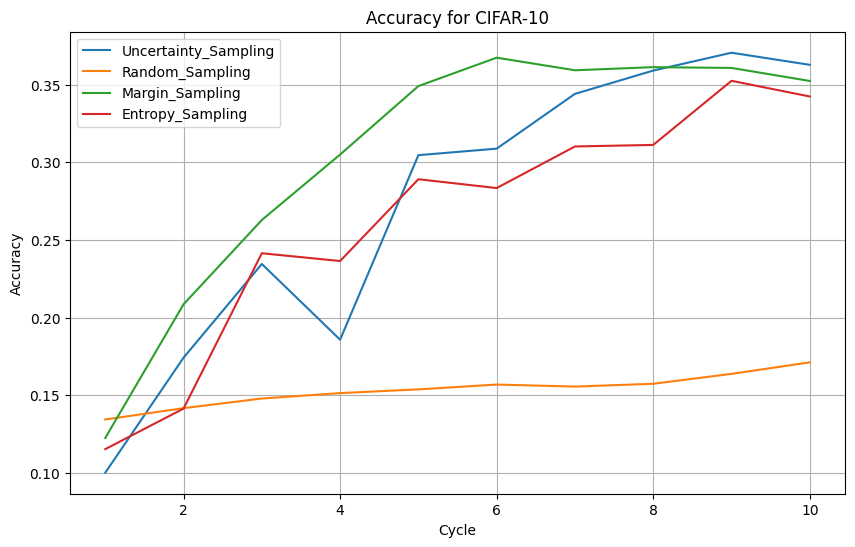

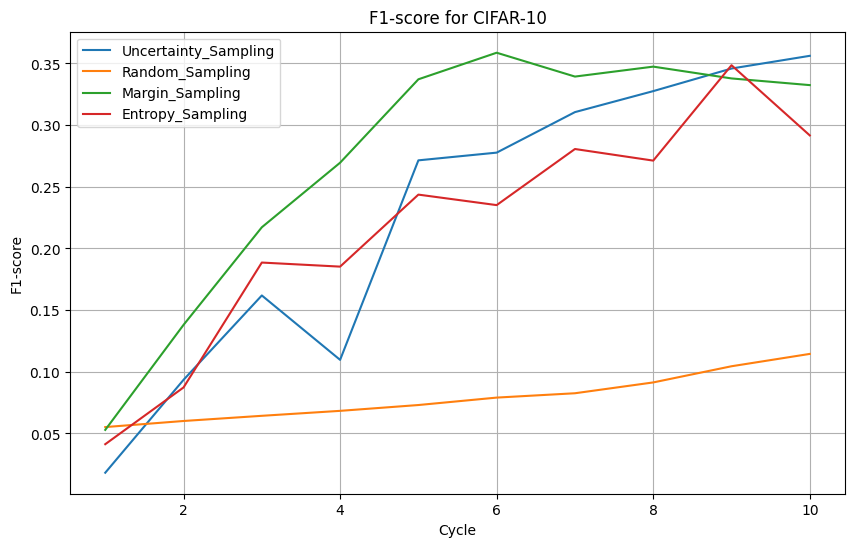

Dataset: Fashion MNIST


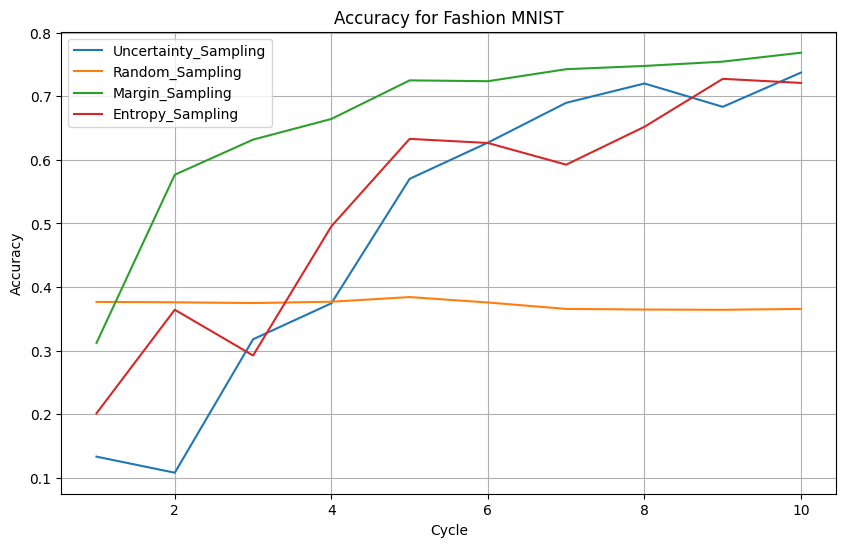

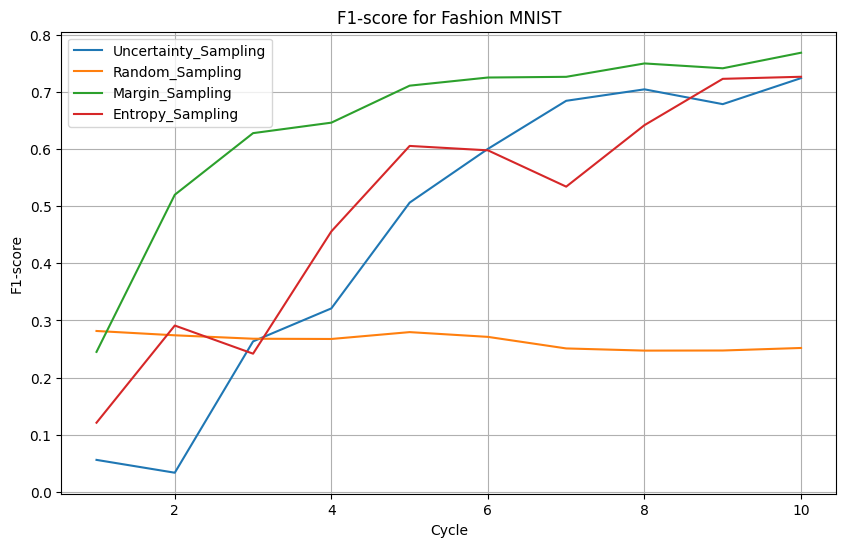

Dataset: Imbalance Fashion MINIST


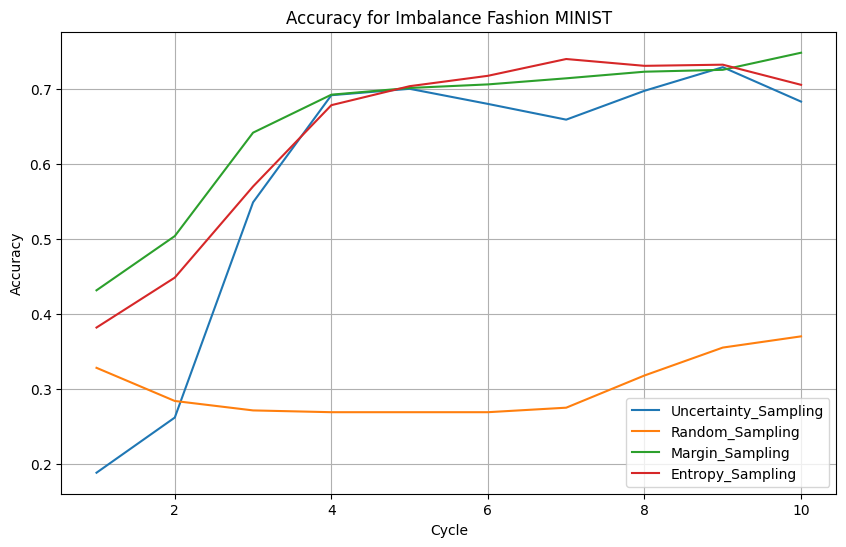

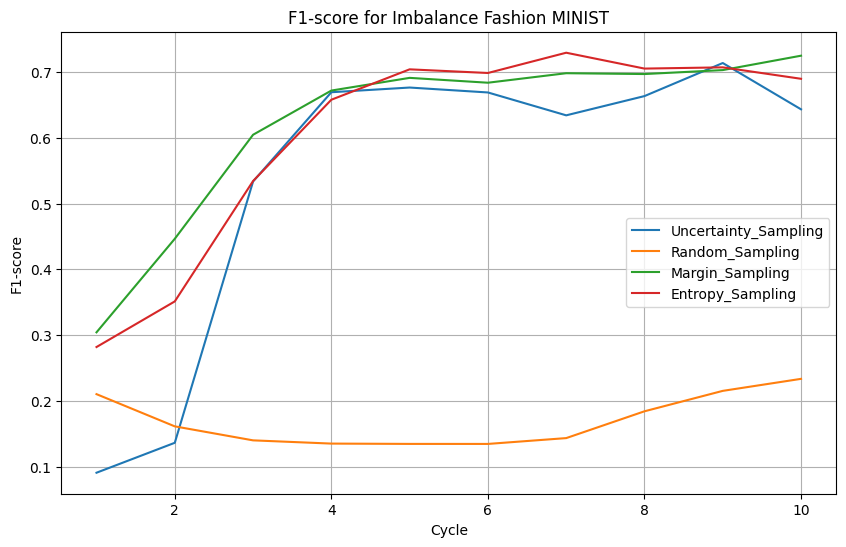

In [23]:
for dataset_name, results in accuracy_results.items():
    print(f"Dataset: {dataset_name}")

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    for strategy_name, metrics in results.items():
        cycle = range(1, len(metrics['accuracy']) + 1)
        plt.plot(cycle, metrics['accuracy'], label=strategy_name)

    plt.title(f"Accuracy for {dataset_name}")
    plt.xlabel("Cycle")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot F1-score
    plt.figure(figsize=(10, 6))
    for strategy_name, metrics in results.items():
        cycle = range(1, len(metrics['f1_score']) + 1)
        plt.plot(cycle, metrics['f1_score'], label=strategy_name)

    plt.title(f"F1-score for {dataset_name}")
    plt.xlabel("Cycle")
    plt.ylabel("F1-score")
    plt.legend()
    plt.grid(True)
    plt.show()